In [1]:
import utils
from dataset import BuildingDataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from model import get_transform
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torch

In [2]:
# Load data for exploration.
dataset_test = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
)

In [3]:
# Load data for exploration.
dataset_expl = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
)

data = [dataset_expl[i] for i in range(10)]
# data = [d for d in dataset_expl]

/Users/volodymyr/work/personal/building_height_detection/.venv/lib/python3.10/site-packages/torchvision/utils.py:224: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


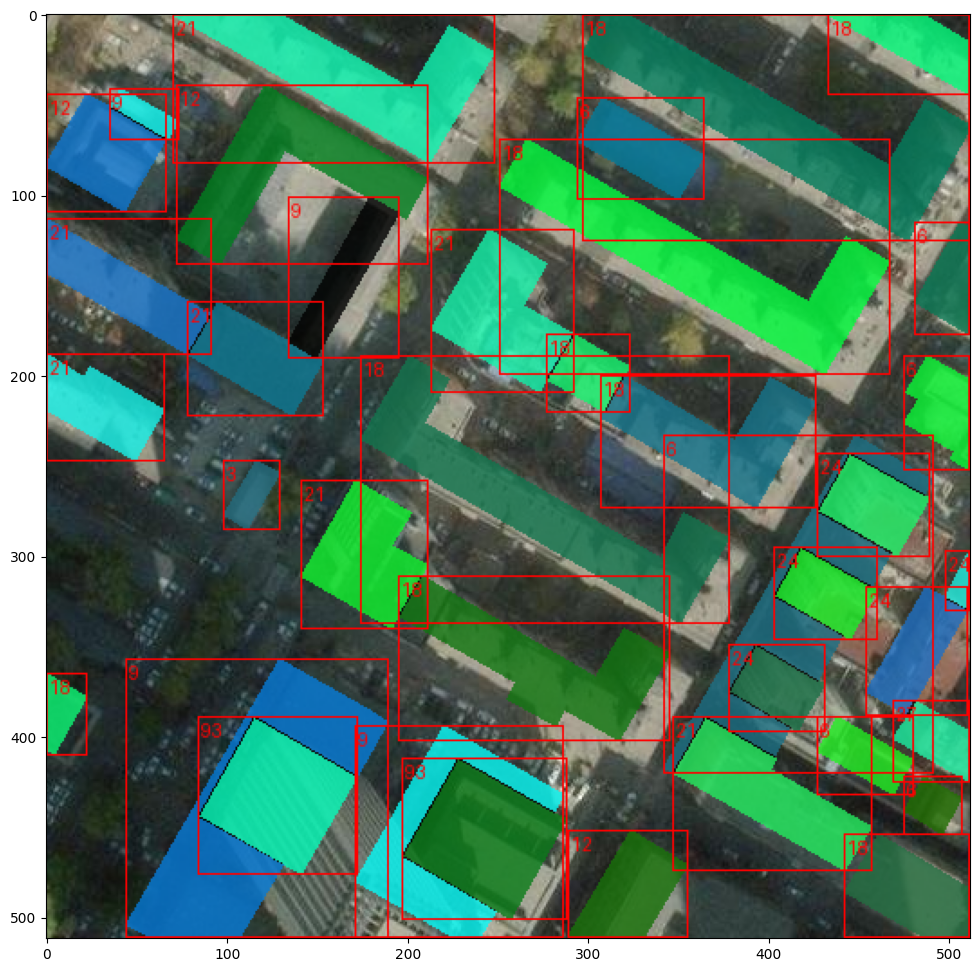

In [4]:
img, masks, boxes = data[2][0], data[2][1]["masks"], data[2][1]["boxes"]

height_labels = [str(h.item()) for h in data[2][1]["building_heights"]]


def show_segmentation(img, masks, boxes=None, bcolors="red"):
    output_image = draw_segmentation_masks(img, masks.to(torch.bool), alpha=0.8)
    if boxes is not None:
        output_image = draw_bounding_boxes(
            output_image, boxes, height_labels, font_size=15, colors=bcolors
        )

    plt.figure(figsize=(12, 12))
    plt.imshow(output_image.permute(1, 2, 0))


show_segmentation(img, masks, boxes)

Quantile 0.25: 3.0
Quantile 0.5: 6.0
Quantile 0.75: 18.0
Quantile 0.95: 24.0
Quantile 0.99: 55.679999999999836


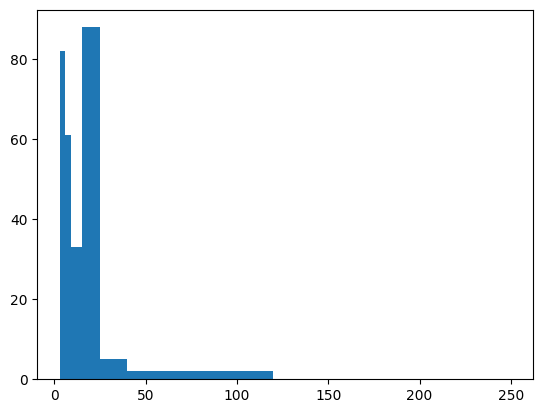

In [6]:
height_labels = [d[1]["building_heights"] for d in data]
height_labels = torch.cat(height_labels).numpy()

counts, bins = np.histogram(
    height_labels,
    bins=[3, 6, 9, 15, 25, 40, 70, 120, 200, max(250, height_labels.max())],
)
plt.stairs(counts, bins, fill=True)

for q in [0.25, 0.5, 0.75, 0.95, 0.99]:
    print(f"Quantile {q}: {np.quantile(height_labels, q)}")

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

dataset = BuildingDataset(
    "datasets/mlc_training_data/images_annotated/",
    transforms=get_transform(train=True),
)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

# For Training
images, targets = next(iter(data_loader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

In [7]:
from model import train

train(
    dataset_root="datasets/mlc_training_data/images_annotated",
    num_epochs=20,
    train_batch_size=10,
)

TypeError: train() missing 1 required positional argument: 'dataset_root'